
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [19]:

import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt

from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, PolynomialFeatures
)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, r2_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, classification_report, f1_score)

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


In [6]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [7]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [8]:
#define x and y
X = ha.drop(columns=['cp'])
y = ha['cp']

In [9]:
ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

In [10]:
X.head()

,age,sex,trtbps,chol,restecg,thalach,output
0,63,1,145,233,0,150,1
1,37,1,130,250,1,187,1
2,56,1,120,236,1,178,1
3,57,0,120,354,1,163,1
4,57,1,140,192,1,148,1


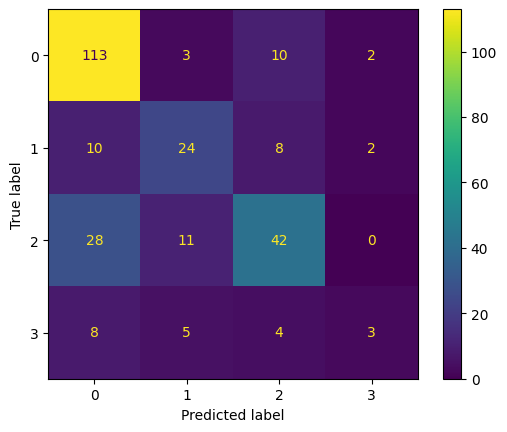

In [11]:
#knns
knn_model1 = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]

).set_output(transform="pandas")
#create a confusion matrix
knn_model1.fit(X, y)
y_pred = knn_model1.predict(X)
#confusion matrix


#create confusion
#matrix
cm1= confusion_matrix(y, y_pred)
cm1
ConfusionMatrixDisplay(cm1).plot()


In [12]:
scores1 = cross_val_score(knn_model1, X, y, cv=5, scoring="roc_auc_ovr").mean()
print(f"roc auc Score: {scores1}")
#import cross_val_Score


roc auc Score: 0.5962262199130134


In [20]:
#decsion tree pipeline
dt_model1 = Pipeline(
    [("preprocessing", ct),
     ("dt", DecisionTreeClassifier(max_depth = 4))]
).set_output(transform="pandas")



dt_model1.fit(X,y)
scores2= cross_val_score(dt_model1, X, y, cv=5, scoring="roc_auc_ovr").mean()
print(f"roc auc Score: {scores2}")


roc auc Score: 0.6163869333484484


In [ ]:
# #tried to grid search
# param_dt = {'decision_tree__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

# grid_search_dt = GridSearchCV(dt_model1, param_dt, cv=5, scoring='f1', n_jobs=-1)

# # Fit the grid search on the data
# grid_search_dt.fit(X, y)

# best_min_impurity_decrease = grid_search_dt.best_params_['decision_tree__min_impurity_decrease']
# best_roc_auc_dt = grid_search_dt.best_score_

# print("Decsion Tree")
# print(f"param {best_min_impurity_decrease}")
# print(f"ROC AUC {best_roc_auc_dt}")

In [17]:
#lda pipeline
lda_model1=Pipeline([
    ("ct", ct),
    ("lda", LinearDiscriminantAnalysis())
])

lda_model1.fit(X,y)
scores3= cross_val_score(lda_model1, X, y, cv=5, scoring="roc_auc_ovr").mean()
print(f"roc auc Score: {scores3}")

roc auc Score: 0.7057410454407037


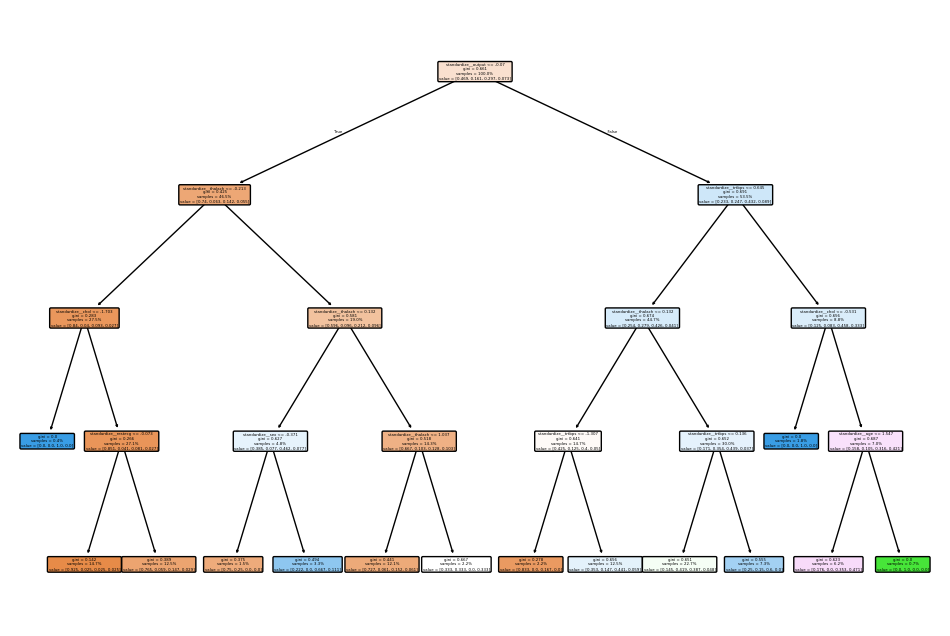

In [21]:
decision_tree = dt_model1.named_steps["dt"]
plt.figure(figsize=(12, 8))
plot_tree(decision_tree, filled=True, feature_names=ct.get_feature_names_out(), rounded=True, proportion=True)
plt.show()

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [23]:
for i in range(4):
    ha[f'cp_is_{i}'] = (ha['cp'] == i).astype(int)

results = {}
#make function to look at cp 0-3
for i in range(4):
    X = ha.drop(columns=['output', 'cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])#drop so not 1
    y = ha[f'cp_is_{i}']

    # fit model
    logreg = LogisticRegression()
    y_pred = cross_val_predict(logreg, X, y, cv=5)  # Generate cross-validated predictions

    #classifaction report
    print(f"Classification Report for cp_is_{i}:\n{classification_report(y, y_pred)}")

    # calc F1 Score
    f1 = f1_score(y, y_pred).mean()
    results[i] = f1
    print(f"F1 Score for cp_is_{i}: {f1}\n")
#best catefgory--> found in dictionary we created
best_category = max(results, key=results.get)
print(f"\nThe OvR approach was best at distinguishing cp category {best_category} with an F1 score of {results[best_category]:.3f}.")

Classification Report for cp_is_0:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       145
           1       0.64      0.56      0.60       128

    accuracy                           0.64       273
   macro avg       0.64      0.64      0.64       273
weighted avg       0.64      0.64      0.64       273

F1 Score for cp_is_0: 0.5975103734439834

Classification Report for cp_is_1:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       229
           1       0.00      0.00      0.00        44

    accuracy                           0.83       273
   macro avg       0.42      0.50      0.45       273
weighted avg       0.70      0.83      0.76       273

F1 Score for cp_is_1: 0.0

Classification Report for cp_is_2:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       192
           1       0.17      0.05      0.08        81

    accu

The f1 ia good at finding the recall. It is good at the target category.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [24]:
ha1= ha[(ha["cp"]==0)|(ha["cp"]==1)]

X2=ha1.drop(columns=["cp_is_2", "cp", "cp_is_3","cp_is_1", "cp_is_0"])
y2=ha1["cp"]

logreg_pipeline=Pipeline([
    ("ct", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

logfit= logreg_pipeline.fit(X2,y2)
scores= cross_val_score(logreg_pipeline, X2, y2, cv=5, scoring="roc_auc").mean()
print(f"roc auc: {scores}")

roc auc: 0.8376709401709401


In [25]:
ha2= ha[(ha["cp"]==0)|(ha["cp"]==2)]

X3=ha2.drop(columns=["cp_is_2", "cp", "cp_is_3","cp_is_1", "cp_is_0"])
y3=ha2["cp"]

logreg_pipeline=Pipeline([
    ("ct", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

logfit= logreg_pipeline.fit(X3,y3)
scores= cross_val_score(logreg_pipeline, X3, y3, cv=5, scoring="roc_auc").mean()
print(f"roc auc: {scores}")

roc auc: 0.7511029411764706


In [27]:
ha3= ha[(ha["cp"]==0)|(ha["cp"]==3)]

X4=ha3.drop(columns=["cp_is_2", "cp", "cp_is_3","cp_is_1", "cp_is_0"])
y4=ha3["cp"]

logreg_pipeline=Pipeline([
    ("ct", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

logfit= logreg_pipeline.fit(X4,y4)
scores= cross_val_score(logreg_pipeline, X4, y4, cv=5, scoring="roc_auc").mean()
print(f"roc auc: {scores}")

roc auc: 0.7412307692307692


In [28]:
ha0= ha[(ha["cp"]==0)|(ha["cp"]==3)]

X4=ha3.drop(columns=["cp_is_2", "cp", "cp_is_3","cp_is_1", "cp_is_0"])
y4=ha3["cp"]

logreg_pipeline=Pipeline([
    ("ct", ct),
    ("logreg", LogisticRegression(max_iter=1000))
])

logfit= logreg_pipeline.fit(X4,y4)
scores= cross_val_score(logreg_pipeline, X4, y4, cv=5, scoring="roc_auc").mean()
print(f"roc auc: {scores}")

roc auc: 0.7412307692307692


In [130]:
# ha_0_1 = ha[ha['cp'].isin([0, 1])]

In [131]:
# #reduce your dataset to only the 0 and 1 types of chest pain.
# ha_2 = ha[ha['cp'].isin([0, 1])]

In [132]:
# # Function to perform OvO logistic regression with cross-validation and return ROC-AUC
# def ovo_logreg_cv(df, cp1, cp2, cv=5):
#     # Subset the data for the two classes being compared
#     subset = df[df['cp'].isin([cp1, cp2])]
#     X = subset.drop(columns=['output', 'cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'])
#     y = (subset['cp'] == cp2).astype(int)  # Binary target: 1 if cp == cp2, 0 otherwise

#     # Logistic Regression with cross-validation
#     logreg = LogisticRegression()
#     y_pred = cross_val_predict(logreg, X, y, cv=5)

#     # Compute ROC-AUC
#     roc_auc = roc_auc_score(y, y_pred)
#     return roc_auc

# # Compare category 0 to 1, 0 to 2, and 0 to 3 using cross-validation
# roc_auc_01 = ovo_logreg_cv(ha, 0, 1, cv=5)
# roc_auc_02 = ovo_logreg_cv(ha, 0, 2, cv=5)
# roc_auc_03 = ovo_logreg_cv(ha, 0, 3, cv=5)

# print(f"ROC-AUC for cp 0 vs 1: {roc_auc_01:.3f}")
# print(f"ROC-AUC for cp 0 vs 2: {roc_auc_02:.3f}")
# print(f"ROC-AUC for cp 0 vs 3: {roc_auc_03:.3f}")

# # Determine the best-performing pair
# results_ovo = {
#     "0 vs 1": roc_auc_01,
#     "0 vs 2": roc_auc_02,
#     "0 vs 3": roc_auc_03
# }
# best_pair_ovo = max(results_ovo, key=results_ovo.get)
# print(f"\nThe OvO approach was best at distinguishing {best_pair_ovo} with an ROC-AUC of {results_ovo[best_pair_ovo]:.3f}.")

ROC-AUC for cp 0 vs 1: 0.624
ROC-AUC for cp 0 vs 2: 0.572
ROC-AUC for cp 0 vs 3: 0.477

The OvO approach was best at distinguishing 0 vs 1 with an ROC-AUC of 0.624.
